In [1]:
import torch

In [2]:
from torch import nn
from torch.autograd import Variable

In [11]:
import numpy as np
N_train = 5000
# Load Data # replace with something else (also will make .pkl file)
data = np.load('single_locus_data.npy', allow_pickle='TRUE')
# with open("single_locus_data.pkl", "wb") as tf:
#     data = pickle.load(tf)    
f = data.item()['f'][:, None]
t = data.item()['t'][:, None]
p = data.item()['phi'][:, None]
print(len(f))
idx_list = np.arange(len(f))
np.random.shuffle(idx_list)
print(idx_list)

f_train = torch.from_numpy(f[idx_list[:N_train]]).float().to(device)
t_train = torch.from_numpy(t[idx_list[:N_train]]).float().to(device)
p_train = torch.from_numpy(p[idx_list[:N_train]]).float().to(device)
f_test = torch.from_numpy(f[idx_list[N_train:]]).float().to(device)
t_test = torch.from_numpy(t[idx_list[N_train:]]).float().to(device)
p_test = torch.from_numpy(p[idx_list[N_train:]]).float().to(device)


11000
[ 3000 10585  8914 ...  7237  7983  5774]


In [3]:
# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )
device = "cuda:1"
print(f"Using {device} device")
torch.cuda.current_device()

Using cuda:1 device


0

In [38]:
class PINN(nn.Module):
    def __init__(self, layers, s0, N0):
        super().__init__()
        self.model = nn.Sequential().to(device)
        for i in range(len(layers)-2):
            self.model.add_module(f"layer{i}", nn.Linear(layers[i], layers[i+1]))
            self.model.add_module(f"activation{i}", nn.Tanh())
        self.model.add_module(f"layer{len(layers)-1}", nn.Linear(layers[-2], layers[-1]))
        self.model.add_module(f"activation{len(layers)-2}", nn.Softplus())

        self.s = torch.nn.Parameter(torch.tensor(s0).float(), requires_grad = True)
        self.invN = torch.nn.Parameter(torch.tensor(1/N0).float(), requires_grad = True)
        # self.N = torch.nn.Parameter(torch.tensor(N0).float(), requires_grad = True)
        # self.s = Variable(torch.tensor(s0).float(), requires_grad = True).to(device)
        # self.N = Variable(torch.tensor(N0).float(), requires_grad = True).to(device)

    def forward(self, f, t):
        inputs = torch.cat([f, t], 1)
        return self.model(inputs)
    def PDE(self, f, t):
        s = self.s
        invN = self.invN
        p = self.model(torch.cat([f, t], 1))
        p_f = torch.autograd.grad(p.sum(), f, create_graph=True)[0]
        p_t = torch.autograd.grad(p.sum(), t, create_graph=True)[0]
        p_ff = torch.autograd.grad(p_f.sum(), f, create_graph=True)[0]
        g = p_t + s * ((1 - 2*f)*p + (f - f**2)*p_f) + invN / 2 * (-2*p + 2*(1 - 2*f)*p_f + (f - f**2)*p_ff)
        return g

# Input = (f, t) series, Output = p series
model = PINN(layers = [2, 20, 20, 20, 1], s0 = 0.1, N0 = 500).to(device)
        

In [39]:
print(model)
for parameter in model.parameters():

    print(parameter)

PINN(
  (model): Sequential(
    (layer0): Linear(in_features=2, out_features=20, bias=True)
    (activation0): Tanh()
    (layer1): Linear(in_features=20, out_features=20, bias=True)
    (activation1): Tanh()
    (layer2): Linear(in_features=20, out_features=20, bias=True)
    (activation2): Tanh()
    (layer4): Linear(in_features=20, out_features=1, bias=True)
    (activation3): Softplus(beta=1, threshold=20)
  )
)
Parameter containing:
tensor(0.1000, device='cuda:0', requires_grad=True)
Parameter containing:
tensor(0.0020, device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.3419, -0.1134],
        [ 0.6227,  0.2506],
        [-0.0905,  0.1731],
        [ 0.5504,  0.0438],
        [ 0.5020, -0.5935],
        [-0.6329,  0.4117],
        [ 0.6977, -0.5384],
        [-0.6699, -0.2377],
        [ 0.0684, -0.4383],
        [-0.6202, -0.3139],
        [ 0.6478, -0.4465],
        [ 0.2038,  0.5151],
        [ 0.0085, -0.6801],
        [ 0.0721,  0.3841],
        [-0.4766,

In [40]:
print(f_train.shape)
model(f_train, t_train)

torch.Size([5000, 1])


tensor([[0.6500],
        [0.6500],
        [0.6500],
        ...,
        [0.6364],
        [0.6500],
        [0.6717]], device='cuda:0', grad_fn=<SoftplusBackward0>)

In [41]:
iterations = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(iterations):
    MSE_loss = nn.MSELoss()
    f_sample = np.random.uniform(low=0.0, high=1.0, size=(500,1))
    pt_f_sample = Variable(torch.from_numpy(f_sample).float(), requires_grad=True).to(device)
    t_sample = np.random.uniform(low=0.0, high=10000, size=(500,1))
    pt_t_sample = Variable(torch.from_numpy(t_sample).float(), requires_grad=True).to(device)
    loss_pde = MSE_loss(model.PDE(pt_f_sample, pt_t_sample), torch.zeros_like(model.PDE(pt_f_sample, pt_t_sample)))
    # In this case, we have p_train to compare directly against estimate of p at f_train, t_train. 
    loss_data = MSE_loss(model(f_train, t_train), p_train)
    loss = loss_pde + loss_data
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    print(epoch,"training loss:", loss.data, "s:", model.s, "N:", 1 / model.invN)


0 training loss: tensor(0.1773, device='cuda:0') s: Parameter containing:
tensor(0.0990, device='cuda:0', requires_grad=True) N: tensor(999.9860, device='cuda:0', grad_fn=<MulBackward0>)
1 training loss: tensor(0.1637, device='cuda:0') s: Parameter containing:
tensor(0.0980, device='cuda:0', requires_grad=True) N: tensor(10439.3809, device='cuda:0', grad_fn=<MulBackward0>)
2 training loss: tensor(0.1516, device='cuda:0') s: Parameter containing:
tensor(0.0970, device='cuda:0', requires_grad=True) N: tensor(-3142.2358, device='cuda:0', grad_fn=<MulBackward0>)
3 training loss: tensor(0.1409, device='cuda:0') s: Parameter containing:
tensor(0.0960, device='cuda:0', requires_grad=True) N: tensor(-2839.6030, device='cuda:0', grad_fn=<MulBackward0>)
4 training loss: tensor(0.1315, device='cuda:0') s: Parameter containing:
tensor(0.0950, device='cuda:0', requires_grad=True) N: tensor(-1602.2446, device='cuda:0', grad_fn=<MulBackward0>)
5 training loss: tensor(0.1233, device='cuda:0') s: Param

In [11]:
# s and N are not updating... why??? ==> solved! self.s and self.N should be torch.nn.Parameter, not Variable.

# Can add to the loss function to keep N non-negative. 

In [42]:
model(f_test, t_test)

tensor([[0.1889],
        [0.0739],
        [0.4350],
        ...,
        [0.0903],
        [0.0377],
        [0.4350]], device='cuda:0', grad_fn=<SoftplusBackward0>)

In [43]:
p_test

tensor([[0.1920],
        [0.0711],
        [0.1487],
        ...,
        [0.0925],
        [0.0104],
        [0.1677]], device='cuda:0')

In [14]:
model.N

Parameter containing:
tensor(500.0162, requires_grad=True)

In [15]:
model.s

Parameter containing:
tensor(0.0478, requires_grad=True)

In [16]:
# Return predicted s and N, plot p(f, t). Plot p(f = 1, t), which is fixation probability as a function of time.

In [38]:
import numpy as np

In [7]:
data_FP = np.load("single_locus_FP_fmatrix.npy")
data_FP.shape
data_FP = torch.from_numpy(data_FP).float().to(device)

In [40]:
f_data = data_FP[0, :].reshape(data_FP.shape[1], 1)
t_data = torch.zeros(data_FP.shape[1]).reshape(data_FP.shape[1], 1).to(device)
torch.cat([f_data, t_data], 1)
torch.cat([torch.linspace(0, 1, 1001).reshape(1001, 1), torch.ones(1001, 1)], 1)


tensor([[0.0000, 1.0000],
        [0.0010, 1.0000],
        [0.0020, 1.0000],
        ...,
        [0.9980, 1.0000],
        [0.9990, 1.0000],
        [1.0000, 1.0000]])

In [25]:
Ntrue = 1e4
class PINN(nn.Module):
    def __init__(self, layers, s0, N0):
        super().__init__()
        self.model = nn.Sequential().to(device)
        for i in range(len(layers)-2):
            self.model.add_module(f"layer{i}", nn.Linear(layers[i], layers[i+1]))
            self.model.add_module(f"activation{i}", nn.Tanh())
        self.model.add_module(f"layer{len(layers)-1}", nn.Linear(layers[-2], layers[-1]))
        self.model.add_module(f"activation{len(layers)-2}", nn.Softplus())

        self.s = torch.nn.Parameter(torch.tensor(s0).float(), requires_grad = True)
        # self.invN = torch.nn.Parameter(torch.tensor(1/N0).float(), requires_grad = True)
        # self.s = Variable(torch.tensor(s0).float(), requires_grad = True).to(device)
        # self.N = Variable(torch.tensor(N0).float(), requires_grad = True).to(device)

    def forward(self, f, t):
        tau = t / Ntrue
        inputs = torch.cat([f, tau], 1)
        return self.model(inputs)
    def PDE(self, f, t):
        s = self.s
        tau = t / Ntrue
        p = self.model(torch.cat([f, tau], 1))
        p_f = torch.autograd.grad(p.sum(), f, create_graph=True)[0]
        p_t = torch.autograd.grad(p.sum(), tau, create_graph=True)[0]
        p_ff = torch.autograd.grad(p_f.sum(), f, create_graph=True)[0]
        g = p_t + s * Ntrue * ((1 - 2*f)*p + (f - f**2)*p_f) + 1 / 2 * (-2*p + 2*(1 - 2*f)*p_f + (f - f**2)*p_ff)
        return g

# Input = (f, t) series, Output = p series
model = PINN(layers = [2, 20, 20, 20, 1], s0 = 0.1, N0 = 500).to(device)

In [26]:
iterations = 10000
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
for epoch in range(iterations):
    MSE_loss = nn.MSELoss()
    # Same pde loss as before (pick random f and t to evaluate pde loss)
    f_sample = np.random.uniform(low=0.0, high=1.0, size=(500,1))
    pt_f_sample = Variable(torch.from_numpy(f_sample).float(), requires_grad=True).to(device)
    t_sample = np.random.uniform(low=0.0, high=10000, size=(500,1))
    pt_t_sample = Variable(torch.from_numpy(t_sample).float(), requires_grad=True).to(device)
    loss_pde = MSE_loss(model.PDE(pt_f_sample, pt_t_sample), torch.zeros_like(model.PDE(pt_f_sample, pt_t_sample)))
    loss_data = 0
    for t in np.random.choice(data_FP.shape[0], 20, replace=False):
        f_data = data_FP[t, :].reshape(data_FP.shape[1], 1)
        t_data = t * torch.ones(data_FP.shape[1], 1).to(device)
        # fix the line below so that it is a torch tensor that is updatable as a loss function.
        loss_data += - 1 / data_FP.shape[1] * torch.sum(torch.log(model(f_data, t_data)))
        num_f_step = 1000
        p_left_right = model(torch.linspace(0, 1, num_f_step + 1).reshape(num_f_step + 1, 1).to(device), t * torch.ones(num_f_step + 1, 1).to(device))
        p_integral = torch.sum(p_left_right[1:] + p_left_right[:-1]) / 2 * 1 / num_f_step
        loss_data += p_integral
    # In this case, we have p_train to compare directly against estimate of p at f_train, t_train. 
    loss = 20 * loss_pde + loss_data
    print(epoch,"training loss:", loss.data, "s:", model.s)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()



0 training loss: tensor(3026917., device='cuda:2') s: Parameter containing:
tensor(0.1000, device='cuda:2', requires_grad=True)
1 training loss: tensor(3018452., device='cuda:2') s: Parameter containing:
tensor(0.0999, device='cuda:2', requires_grad=True)
2 training loss: tensor(2951895.5000, device='cuda:2') s: Parameter containing:
tensor(0.0998, device='cuda:2', requires_grad=True)
3 training loss: tensor(2907927., device='cuda:2') s: Parameter containing:
tensor(0.0997, device='cuda:2', requires_grad=True)
4 training loss: tensor(3103082.7500, device='cuda:2') s: Parameter containing:
tensor(0.0996, device='cuda:2', requires_grad=True)
5 training loss: tensor(2916184., device='cuda:2') s: Parameter containing:
tensor(0.0995, device='cuda:2', requires_grad=True)
6 training loss: tensor(2907901.2500, device='cuda:2') s: Parameter containing:
tensor(0.0994, device='cuda:2', requires_grad=True)
7 training loss: tensor(3104905., device='cuda:2') s: Parameter containing:
tensor(0.0993, d

In [27]:
model(f_test, t_test)

tensor([[0.0098],
        [0.0124],
        [0.0123],
        ...,
        [0.0120],
        [0.0100],
        [0.0122]], device='cuda:2', grad_fn=<SoftplusBackward0>)

In [28]:
p_test

tensor([[0.1680],
        [0.1085],
        [0.5552],
        ...,
        [0.7238],
        [0.0058],
        [0.5775]], device='cuda:2')

In [29]:
f_plot = np.arange(0, 1, 0.01)
t_plot = np.arange(0, 2000, 1)
ms_f, ms_t = np.meshgrid(f_plot, t_plot)

f = np.ravel(ms_f).reshape(-1, 1)
t = np.ravel(ms_t).reshape(-1, 1)
pt_f = Variable(torch.from_numpy(f).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_p = model(pt_f, pt_t)

p = pt_p.data.cpu().numpy()
ms_p = p.reshape(ms_f.shape)



OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 2; 79.15 GiB total capacity; 98.80 MiB already allocated; 14.44 MiB free; 114.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

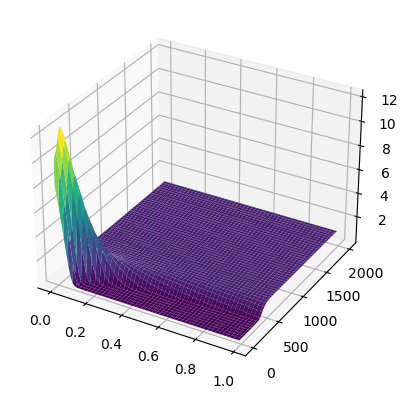

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(ms_f, ms_t, ms_p, cmap='viridis', linewidth=0)

Text(0, 0.5, 'generation (t)')

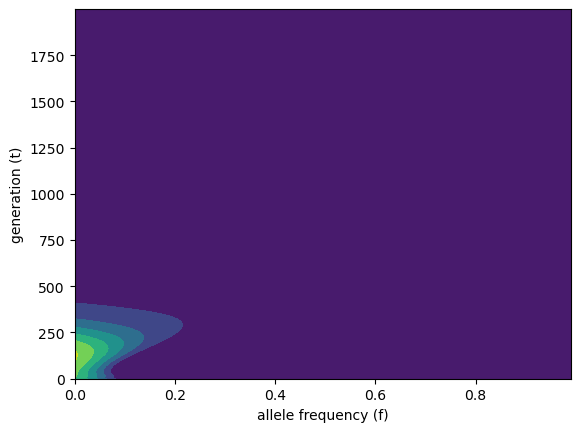

In [16]:
plt.contourf(ms_f, ms_t, ms_p)
plt.xlabel('allele frequency (f)')
plt.ylabel('generation (t)')

In [31]:
model.s

Parameter containing:
tensor(0.0347, device='cuda:2', requires_grad=True)

In [ ]:
## The plot doesn't look too bad?? But the estimate for s is about 1/10 of true value. (true s = 0.01, true N = 1e4)

In [ ]:
## Training is super slow with the new loss function that takes in f and t data.
## Need to implement batch training. It's also time to add mutation, and expand the model to two locus (adds recombination)

In [7]:
import numpy as np
two_locus_data = np.loadtxt("two_locus_trajectory.csv")

In [8]:
## data[:, 1:9] are genotype frequencies. The last few are s1, s2, and other non-time dependent information
## p(f, t|s1, s2, h1, h2, mu1, mu2, r, N) is what we want. 
## Write down equation for p based on Hill and Robertson. I might ignore h1 and h2 for simplicity. 
## Modify based on Ragsdale 2022 SI. (There are many terms, so it might be better to loop over some similar terms.)

## Figure out dimensions of the input and output of the torch.autograd.grad (tensor of same size?)
class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.model = nn.Sequential().to(device)
        for i in range(len(layers)-2):
            self.model.add_module(f"layer{i}", nn.Linear(layers[i], layers[i+1]))
            self.model.add_module(f"activation{i}", nn.Tanh())
        self.model.add_module(f"layer{len(layers)-1}", nn.Linear(layers[-2], layers[-1]))
        self.model.add_module(f"activation{len(layers)-2}", nn.Softplus())


    def forward(self, fAB, fAb, faB, t, s1, s2, mu1, mu2, R, N):
        tau = t / N
        inputs = torch.cat([fAB, fAb, faB, tau, s1, s2, mu1, mu2, R, N], 1)
        return self.model(inputs)
    def PDE(self, fAB, fAb, faB, t, s1, s2, mu1, mu2, R, N):
        
        tau = t / N
        p = self.model(torch.cat([fAB, fAb, faB, tau, s1, s2, mu1, mu2, R, N], 1))
        fab = 1 - fAB - fAb - faB
        D = fAB * fab - fAb * faB

        indep_genotypes = [fAB, fAb, faB]
        s12 = s1 + s2
        selection_coeffs = [s12, s1, s2]
        D_sign = [1, -1, -1]

        #### I need to use the input (second entry) of autograd.grad to be one of the inputs in self.model
        dummy = torch.autograd.grad((p * fAB).sum(), fAB, create_graph=True)[0]
        
        drift_terms = torch.autograd.grad(torch.autograd.grad((p*fAB*(1-fAB)).sum(), fAB, create_graph=True)[0].sum(), fAB, create_graph=True)[0] / 4
        drift_terms += torch.autograd.grad(torch.autograd.grad((p*fAb*(1-fAb)).sum(), fAb, create_graph=True)[0].sum(), fAb, create_graph=True)[0] / 4
        drift_terms += torch.autograd.grad(torch.autograd.grad((p*faB*(1-faB)).sum(), faB, create_graph=True)[0].sum(), faB, create_graph=True)[0] / 4

        drift_terms += -torch.autograd.grad(torch.autograd.grad((p*fAB*fAb).sum(), fAB, create_graph=True)[0].sum(), fAb, create_graph=True)[0] / 2
        drift_terms += -torch.autograd.grad(torch.autograd.grad((p*fAB*faB).sum(), fAB, create_graph=True)[0].sum(), faB, create_graph=True)[0] / 2
        drift_terms += -torch.autograd.grad(torch.autograd.grad((p*fAb*faB).sum(), fAb, create_graph=True)[0].sum(), faB, create_graph=True)[0] / 2


        mean_s = fAB * (s1 + s2) + fAb * s1 + faB * s2

        selection_terms = -1/2 * torch.autograd.grad((fAB * (s1 + s2 - mean_s) * p).sum(), fAB, create_graph=True)[0]
        selection_terms += -1/2 * torch.autograd.grad((fAb * (s1 - mean_s) * p).sum(), fAb, create_graph=True)[0]
        selection_terms += -1/2 * torch.autograd.grad((faB * (s2 - mean_s) * p).sum(), faB, create_graph=True)[0]

        fab = 1 - fAB - fAb - faB
        D = fAB * fab - fAb * faB


        recombination_terms = torch.zeros(1)
        recombination_terms = R * torch.autograd.grad((D * p).sum(), fAB, create_graph=True)[0]
        recombination_terms += R * torch.autograd.grad((-D * p).sum(), fAb, create_graph=True)[0]
        recombination_terms += R * torch.autograd.grad((-D * p).sum(), faB, create_graph=True)[0]

        mutation_terms = -1/2 * torch.autograd.grad((p * (mu1 * faB + mu2 * fAb)).sum(), fAB, create_graph=True)[0]
        mutation_terms += -1/2 * torch.autograd.grad((p * mu1 * fab).sum(), fAb, create_graph=True)[0]
        mutation_terms += -1/2 * torch.autograd.grad((p * mu2 * fab).sum(), faB, create_graph=True)[0]

        p_tau = torch.autograd.grad(p.sum(), tau, create_graph=True)[0]

        g = -p_tau + drift_terms + selection_terms + recombination_terms + mutation_terms

        return g

# Input = (f, t) series, Output = p series
model = PINN(layers = [10, 40, 40, 40, 40, 1]).to(device)

In [9]:
two_locus_data = np.loadtxt("two_locus_trajectory.csv")
t0_idx = np.where((two_locus_data[:, 0] < 2) * (two_locus_data[:, 0] > 0))[0]
sim_length = t0_idx[1:] - t0_idx[:-1]
print(len(sim_length))
sim_length = np.append(sim_length,[len(two_locus_data[:,0]) - t0_idx[-1]])
print(sim_length)
tmax = max(sim_length)
print(len(sim_length))

19
[10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
 10000 10000 10000 10000 10000 10000 10000 10000]
20


In [10]:
two_locus_data_torch = torch.from_numpy(two_locus_data).float().to(device)


In [11]:
t_data = torch.broadcast_to(torch.arange(tmax), (len(sim_length), tmax)).T
fAB_data = two_locus_data_torch[:, 1] + two_locus_data_torch[:, 2] / 2 + two_locus_data_torch[:, 4] / 2 + two_locus_data_torch[:, 5] / 4
fAB_data = fAB_data.reshape(tmax, len(sim_length))
fAb_data = two_locus_data_torch[:, 2] / 2 + two_locus_data_torch[:, 3] + two_locus_data_torch[:, 5] / 4 + two_locus_data_torch[:, 6] / 2
fAb_data = fAb_data.reshape(tmax, len(sim_length))
faB_data = two_locus_data_torch[:, 4] / 2 + two_locus_data_torch[:, 5] / 4 + two_locus_data_torch[:, 7] + two_locus_data_torch[:, 8] / 2
faB_data = faB_data.reshape(tmax, len(sim_length))
s1_data = two_locus_data_torch[:, 10].reshape(tmax, len(sim_length))
s2_data = two_locus_data_torch[:, 11].reshape(tmax, len(sim_length))
mu1_data = two_locus_data_torch[:, 12].reshape(tmax, len(sim_length))
mu2_data = two_locus_data_torch[:, 13].reshape(tmax, len(sim_length))
r_data = two_locus_data_torch[:, 14].reshape(tmax, len(sim_length))
N_data = two_locus_data_torch[:, 15].reshape(tmax, len(sim_length))


In [5]:
pip install torchquad

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 85.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 6.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [13]:
from torchquad import MonteCarlo, set_up_backend
set_up_backend("torch")
mc = MonteCarlo()

In [15]:
iterations = 10000
n_res = 500 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
for epoch in range(iterations):
    MSE_loss = nn.MSELoss()
    # Same pde loss as before (pick random f and t to evaluate pde loss)

    fAB_sample = np.random.uniform(low=0.0, high=1.0, size=(n_res,1))
    fAb_sample = np.random.uniform(low=0.0, high=1.0-fAB_sample, size=(n_res,1))
    faB_sample = np.random.uniform(low=0.0, high=1.0-fAB_sample-fAb_sample, size=(n_res,1))
    pt_fAB_sample = Variable(torch.from_numpy(fAB_sample).float(), requires_grad=True).to(device)
    pt_fAb_sample = Variable(torch.from_numpy(fAb_sample).float(), requires_grad=True).to(device)
    pt_faB_sample = Variable(torch.from_numpy(faB_sample).float(), requires_grad=True).to(device)
    
    pt_t_sample = torch.rand(n_res, 1, requires_grad=True).to(device) * tmax

    s1_sample = torch.ones(n_res,1).to(device) * (-1e-5) # I could use randomized s to test how well it generalize to multiple values of s
    s2_sample = torch.ones(n_res,1).to(device) * (-1e-5)
    mu1_sample = torch.ones(n_res,1).to(device) * 1e-5
    mu2_sample = torch.ones(n_res,1).to(device) * 1e-5
    R_sample = torch.ones(n_res,1).to(device) * 0.01
    N_sample = torch.ones(n_res,1).to(device) * 1e5
        
    loss_pde = MSE_loss(model.PDE(pt_fAB_sample, pt_fAb_sample, 
    pt_faB_sample, pt_t_sample, s1_sample, s2_sample, mu1_sample, mu2_sample, R_sample, N_sample), 
    torch.zeros_like(model.PDE(pt_fAB_sample, pt_fAb_sample, pt_faB_sample, 
    pt_t_sample, s1_sample, s2_sample, mu1_sample, mu2_sample, R_sample, N_sample)))

    loss_data = 0
    for t in np.random.choice(tmax, 20, replace=False):
        fAB_datapts = fAB_data[t, :].reshape(fAB_data.shape[1], 1)
        fAb_datapts = fAb_data[t, :].reshape(fAb_data.shape[1], 1)
        faB_datapts = faB_data[t, :].reshape(faB_data.shape[1], 1)
        
        t_datapts = t * torch.ones(fAB_data.shape[1], 1).to(device)
        s1_datapts = s1_data[t, :].reshape(s1_data.shape[1], 1)
        s2_datapts = s2_data[t, :].reshape(s2_data.shape[1], 1)
        mu1_datapts = mu1_data[t, :].reshape(mu1_data.shape[1], 1)
        mu2_dtapts = mu2_data[t, :].reshape(mu2_data.shape[1], 1)
        r_datapts = r_data[t, :].reshape(r_data.shape[1], 1)
        N_datapts = N_data[t, :].reshape(N_data.shape[1], 1)
    
        # fix the line below so that it is a torch tensor that is updatable as a loss function.
        loss_data += - 1 / fAB_data.shape[1] * torch.sum(torch.log(model(fAB_datapts, fAb_datapts, faB_datapts, t_datapts, s1_datapts, s2_datapts, mu1_datapts, mu2_dtapts, r_datapts, N_datapts)))
        num_f_step = 1000

        # Currently s1, s2, mu1, mu2, R, N are all fixed. So sample one of them and broadcast to the same size as fAB_space, fAb_space, faB_space
        s1 = s1_datapts[0, 0]
        s2 = s2_datapts[0, 0]
        mu1 = mu1_datapts[0, 0]
        mu2 = mu2_dtapts[0, 0]
        R = r_datapts[0, 0]
        N = N_datapts[0, 0]

        # mc doesn't work because it doesn't recognize model as a function...
        # may have to write a Monte Carlo integration function from scratch (I = volumne of domain / number of sample points * sum of model(sample point)'s)
        p_integral = mc.integrate(model, dim=10, N=num_f_step, integration_domain=[[0,1],[0,1],[0,1],[t,t],[s1,s1],[s2,s2],[mu1,mu1],[mu2,mu2],[R,R],[N,N]], backend='torch')

        # f_space_1d = torch.linspace(0, 1, num_f_step + 1)
        # fAB_space = torch.broadcast_to(f_space_1d[:, None, None], (num_f_step+1, num_f_step+1, num_f_step+1)).reshape((num_f_step+1)**3, 1).to(device)
        # fAb_space = torch.broadcast_to(f_space_1d[None, :, None], (num_f_step+1, num_f_step+1, num_f_step+1)).reshape((num_f_step+1)**3, 1).to(device)
        # faB_space = torch.broadcast_to(f_space_1d[None, None, :], (num_f_step+1, num_f_step+1, num_f_step+1)).reshape((num_f_step+1)**3, 1).to(device)

        # # Need a domain mask that is 1 if fAB + fAb + faB <= 1, 0 otherwise
        # mask = (fAB_space + fAb_space + faB_space <= 1).float().to(device)


        # p_left_right = model(fAB_space, fAb_space, faB_space, t * torch.ones((num_f_step+1)**3, 1).to(device), 
        #     s1 * torch.ones((num_f_step+1)**3, 1).to(device), s2 * torch.ones((num_f_step+1)**3, 1).to(device),
        #     mu1 * torch.ones((num_f_step+1)**3, 1).to(device), mu2 * torch.ones((num_f_step+1)**3, 1).to(device),
        #     R * torch.ones((num_f_step+1)**3, 1).to(device), N * torch.ones((num_f_step+1)**3, 1).to(device))
        # p_left_right = p_left_right.reshape(num_f_step+1, num_f_step+1, num_f_step+1)
        # p_integral = torch.sum(p_left_right[1:,1:,1:]+p_left_right[1:,:-1,1:]
        #                        +p_left_right[1:,1:,:-1]+p_left_right[1:,:-1,:-1]
        #                        +p_left_right[:-1,1:,1:]+p_left_right[:-1,:-1,1:]
        #                        +p_left_right[:-1,1:,:-1]+p_left_right[:-1,:-1,:-1])/ 8 /num_f_step**3
        loss_data += p_integral
    # In this case, we have p_train to compare directly against estimate of p at f_train, t_train. 
    loss = 20 * loss_pde + loss_data
    print(epoch,"training loss:", loss.data)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

TypeError: PINN.forward() missing 9 required positional arguments: 'fAb', 'faB', 't', 's1', 's2', 'mu1', 'mu2', 'R', and 'N'

In [2]:
import gpustat

ModuleNotFoundError: No module named 'gpustat'

In [31]:
flist = np.linspace(0, 1, 10)
ftile1 = np.broadcast_to(flist[:, None, None], (10, 10,10))
ftile2 = np.broadcast_to(flist[None, None, :], (10, 10,10))


In [33]:
ftile1[:,0,0]

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [36]:
ftile2[0,0, :]

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])